In [1]:
import raytracer as rt
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
%matplotlib notebook

In [3]:
env = [rt.Obstacle([(0.4, 0), (0.4, 1), (0.6, 1), (0.6, 0)], 1.0, 2.7),
       rt.Obstacle([(2.4, -1), (2.4, 2), (2.6, 2), (2.6, -1)], 1.0, 2.7),
       rt.Obstacle([(0, 1.25), (0, 1.5), (2, 1.5), (2, 1.25)], 1.0, 2.7)]

In [4]:
ray = rt.Ray((1.5, 0.5), (-1, 1))

<IPython.core.display.Javascript object>


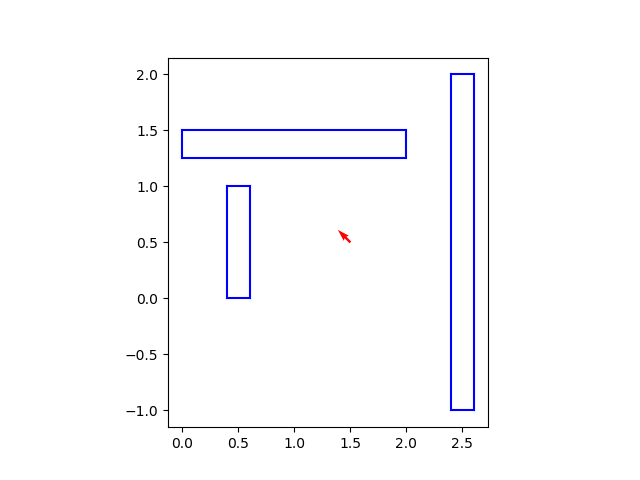

In [5]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

for obstacle in env:
    for boundary in obstacle.boundaries:
        ax.plot([boundary.p0[0], boundary.p1[0]], [boundary.p0[1], boundary.p1[1]], c='b')

# for r in rays:
#     ax.quiver([r.p0[0]], [r.p0[1]], [r.d[0]], [r.d[1]], color='r')
ax.quiver([ray.p0[0]], [ray.p0[1]], [ray.d[0]], [ray.d[1]], color='r')
# x, y = zip(*ps)
# ax.plot(x, y, marker='x', c='r')
# ax.plot([x[0], x[-1]], [y[0], y[-1]], ls='--', c='r')

In [6]:
ps = [tuple(ray.p0)]
hit = rt.closest_hit(ray, env)
while hit is not None:
    print('DONE')
    d, b = hit
    ray.prop(d)
    ps.append(tuple(ray.p0))
    ray = b.reflect(ray)
    hit = rt.closest_hit(ray, env)

DONE
DONE
DONE


In [7]:
ps

[(1.5, 0.5), (0.75, 1.25), (0.5, 1.0), (0.25, 1.25)]

<IPython.core.display.Javascript object>


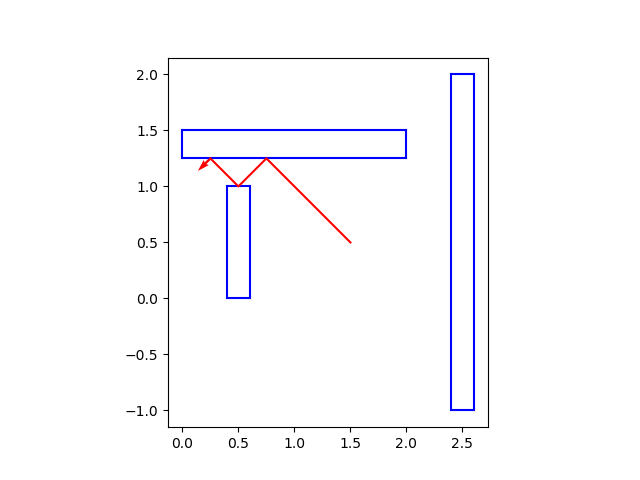

In [8]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

for obstacle in env:
    for boundary in obstacle.boundaries:
        ax.plot([boundary.p0[0], boundary.p1[0]], [boundary.p0[1], boundary.p1[1]], c='b')

x, y = zip(*ps)
ax.plot(x, y, c='r')
ax.quiver([ray.p0[0]], [ray.p0[1]], [ray.d[0]], [ray.d[1]], color='r')

In [9]:
# rays = [rt.Ray((1.5, 0.5), (-1, 1))]
rays = [rt.Ray((1.5, 0.5), (np.cos(a), np.sin(a))) for a in 2*np.pi*np.random.rand(10)]
ps = [[tuple(ray.p0)] for ray in rays]

i = 0
while i < 100:
    ray_i, ray = min(enumerate(rays), key=lambda x: x[1].tof)
#     ray_i = np.random.choice(len(rays))
#     ray = rays[ray_i]
#     print('selected', ray)
    hit = rt.closest_hit(ray, env)
    if hit:
        d, b = hit
        ray.prop(d)
        ps[ray_i].append(tuple(ray.p0))
        refl = b.reflect(ray)
        refr = b.refract(ray)
        rays[ray_i] = refl
        if refr:
            rays.append(refr)
            ps.append(copy.deepcopy(ps[ray_i]))
        else:
#             print('total internal reflection')
            pass
    else:
        ray.prop(5) # prop max
        ps[ray_i].append(tuple(ray.p0))
#         print('no hit')
        pass
#         print([id(r) for r in rays])
#     print(rays)
#     print(ps)
    i += 1

<IPython.core.display.Javascript object>


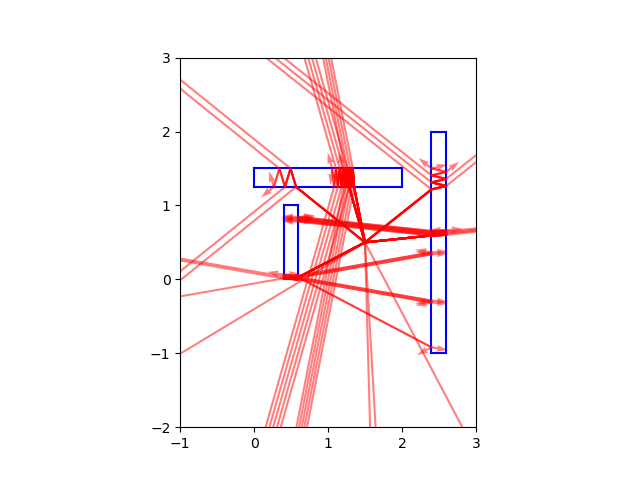

(-2, 3)

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

for obstacle in env:
    for boundary in obstacle.boundaries:
        ax.plot([boundary.p0[0], boundary.p1[0]], [boundary.p0[1], boundary.p1[1]], c='b')

for points in ps:
#     print(points)
    x, y = zip(*points)
    ax.plot(x, y, c='r', alpha=0.5)
    
for ray in rays:
    ax.quiver([ray.p0[0]], [ray.p0[1]], [ray.d[0]], [ray.d[1]], color='r', alpha=0.5)
    
ax.set_xlim([-1, 3])
ax.set_ylim([-2, 3])